# Data preparation: from raw to analyzable data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
os.chdir('/Users/yingli/Development/TopicsInDataScience/')
df = pd.read_csv('dhs_service_records_synthesized_final.csv')

### make the pre-processing into a function
* gather all the data cleaning and transformation from past notebooks
* put into functions


In [3]:
def dhs_preprocessing(df):

    ''' Data cleaning rules we follow in this work
        drop the columns that contain NA entirely
        drop the columns that has only one value in its entirety as they have not information. 
        
        because we do not know enough details about how the reocrd data are created/collected
        we will not remove records with age greater than a value, 
        nor will we remove records with seemingly conflict between age and education level
    ''' 
    df.dropna(axis=1, how='all', inplace=True) 
    df.drop(['synthetic_data', 'CALDR_YR'], axis=1, inplace=True) 

    ''' Data transformation we will apply for this work
        lower the case of the column names
        change some column names for ease of remembering 
        add a column for month name 
        change some columns into categorical type
    '''
    df.rename(columns=str.lower, inplace=True) 
    df.rename(columns = {'mci_uniq_id': 'id', 
                        'date_of_event': 'date', 
                        'marital_status': 'marital', 
                        'education_level':'education'}, inplace=True) 
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df["date"].dt.month_name()

    df = df.astype({'id':'category', 
                    'service':'category',
                    'age': 'int',
                    'gender':'category',
                    'race':'category',
                    'marital':'category',
                    'education':'category'})
    return df

In [4]:
df = dhs_preprocessing(df)
df.head()

,id,date,service,age,gender,race,ethnicity,marital,education,month
0,1626,2021-01-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),January
1,1626,2021-02-28,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),February
2,1626,2021-03-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),March
3,1626,2021-04-30,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),April
4,1626,2021-05-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),May


### further transformations

* transform age into age bin

In [5]:
bin_upper = np.linspace(0, 100, 11).astype(int) # create bins
bin_lower = np.roll (np.linspace(0, 100, 11).astype(int) -1, -1 ) # get the value of one lower of the bin max

bin_name = [ a +'-' + b for a,b in zip(bin_upper.astype(str), bin_lower.astype(str))] # put the two ends of the bin goether as bin names
bin_name[-1]=bin_upper.astype(str)[-1] + '+' # modify the bin name for the last bin
bin_name_map = dict(zip(range(1, 1+len(bin_name)), bin_name)) # mkae the dictionary for mapping
df['age_bin_number'] = np.digitize(df.age, bin_upper) # put actual age into bins
df["age_bin"] = df["age_bin_number"].map(bin_name_map).astype('category') # map the age bin number into the bin name

* create a dictionary that maps service name to a simple string, e.g., "S01", "S12", etc., for ease of handling

In [6]:
serv_list =  ['S'+str(i).zfill(2) for i in range(1,1+df.service.unique().shape[0])] # create list of S01, S02, ..., S22
service_map = dict(zip(df.service.unique(), serv_list)) # create a dictionary of service names to S01, S02, ..., S22
def service_lookup(serv,service_map): # look up the service name by service label S01, S02, etc.
    return next(key for key, value in service_map.items() if value == serv)

In [7]:
service_lookup("S01",service_map)

'Children_Attending_Early_Childhood_Programs_Managed_by_DHS'

In [8]:
df['serv'] = df['service'].map(service_map)

### reverse look up service names 

In [9]:
df['serv'].apply(lambda x: service_lookup(x,service_map))

0          Children_Attending_Early_Childhood_Programs_Ma...
1          Children_Attending_Early_Childhood_Programs_Ma...
2          Children_Attending_Early_Childhood_Programs_Ma...
3          Children_Attending_Early_Childhood_Programs_Ma...
4          Children_Attending_Early_Childhood_Programs_Ma...
                                 ...                        
7116129                                             Suicides
7116130                                             Suicides
7116131                                             Suicides
7116132                                             Suicides
7116133                                             Suicides
Name: serv, Length: 7116134, dtype: category
Categories (22, object): ['Children_Attending_Early_Childhood_Programs_M..., 'Children_Receiving_Child_Welfare_Services', 'Children_Receiving_DHS_Funded_Out_of_School_P..., 'Children_Receiving_Early_Intervention_Services', ..., 'Older_Adults_Receiving_Services', 'Overdoses', 'Parents

In [10]:
service_map

{'Children_Attending_Early_Childhood_Programs_Managed_by_DHS': 'S01',
 'Children_in_Care': 'S02',
 'Children_Receiving_Child_Welfare_Services': 'S03',
 'Children_Receiving_DHS_Funded_Out_of_School_Programs': 'S04',
 'Children_Receiving_Early_Intervention_Services': 'S05',
 'Families_Receiving_Child_Welfare_Services': 'S06',
 'Homeless_Population': 'S07',
 'Homicides': 'S08',
 'Individuals_Receiving_DHS_Services': 'S09',
 'Individuals_Receiving_Family_Strengthening_Programs': 'S10',
 'Individuals_Receiving_Homelessness_and_Housing_Services': 'S11',
 'Individuals_Receiving_Income_Supports': 'S12',
 'Individuals_Receiving_Intellectual_Disability_Services': 'S13',
 'Individuals_Receiving_Mental_Health_Services': 'S14',
 'Individuals_Receiving_Substance_Use_Disorder_Services': 'S15',
 'Involuntary_Commitments': 'S16',
 'Jail_Population': 'S17',
 'Mental_Health_Crises': 'S18',
 'Older_Adults_Receiving_Services': 'S19',
 'Overdoses': 'S20',
 'Parents_Receiving_Child_Welfare_Services': 'S21',


In [11]:
df.head()

,id,date,service,age,gender,race,ethnicity,marital,education,month,age_bin_number,age_bin,serv
0,1626,2021-01-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),January,1,0-9,S01
1,1626,2021-02-28,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),February,1,0-9,S01
2,1626,2021-03-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),March,1,0-9,S01
3,1626,2021-04-30,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),April,1,0-9,S01
4,1626,2021-05-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),May,1,0-9,S01


In [12]:
df[df['serv']=='S14'].id.nunique()

55263

### modify the attribute functions previously written
* retain all variables in the input dataframe except the ones that are being aggregated over

In [13]:
def get_recipient_attribute(df,remove_unused_id = True):  # making the removal of unused ID to be default
    if remove_unused_id:    
        recipient = df.groupby(df['id'].cat.remove_unused_categories()).agg(
            num_service = ('service', 'count'),
            distinct_service = ('service', 'nunique'), 
            first_date = ('date', 'min'), 
            last_date = ('date', 'max'), 
            num_month = ('month', 'count'), 
            distinct_month = ('month', 'nunique')
        ).reset_index()
    else:
        recipient = df.groupby(['id']).agg(
            num_service = ('service', 'count'),
            distinct_service = ('service', 'nunique'), 
            first_date = ('date', 'min'), 
            last_date = ('date', 'max'), 
            num_month = ('month', 'count'), 
            distinct_month = ('month', 'nunique')
        ).reset_index()
    # do not include the columns that were keys to the groups for aggregation, 'service', 'date', 'month' in this case
    recipient = pd.merge(recipient, df.drop(['service','date','month'],axis=1), on='id', how='left')
    recipient = recipient.drop_duplicates(subset=['id'])
    
    return recipient

def get_recipient_month_attribute(df):
    recipient_month = df.groupby(['id', 'date']).agg(
        num_service = ('service', 'count'),
    ).reset_index()
    recipient_month = pd.merge(recipient_month, df.drop(['service','date','month'],axis=1), on='id', how='left')
    recipient_month = recipient_month.drop_duplicates(subset=['id', 'date'])

    return recipient_month

* now when we call get_recipient_attribute, we would get the newly added variables through

### put the new transformations into functions
* add service labels S01, S02, ...
* add age bins, 0-9, 10-19, ...

In [14]:
def add_service_label(df):
    serv_list =  ['S'+str(i).zfill(2) for i in range(1,1+df.service.unique().shape[0])] # create list of S01, S02, ..., S22
    service_map = dict(zip(df.service.unique(), serv_list)) # create a dictionary of service names to S01, S02, ..., S22
    df['serv'] = df['service'].map(service_map) #adding a new column with the service label
    return df, service_map # service_map need to be returned if we ever want to do a reverse lookup

def service_lookup(serv, service_map): # look up the service name by service label S01, S02, etc.
    return next(key for key, value in service_map.items() if value == serv)

def add_age_bin(df):
    bins = np.linspace(0, 100, 11).astype(int) # create bins
    bins_lower = np.roll (np.linspace(0, 100, 11).astype(int) -1, -1 ) # get the value of one lower of the bin max

    bin_names = [ a +'-' + b for a,b in zip(bins.astype(str), bins_lower.astype(str))] # put the two ends of the bin goether as bin names
    bin_names[-1]=bins.astype(str)[-1] + '+' # modify the bin name for the last bin
    bin_name_map = dict(zip(range(1, 1+len(bin_names)), bin_names)) # mkae the dictionary for mapping
    df['age_bin'] = np.digitize(df.age, bins) # put actual age into bins
    df["age_bin"] = df["age_bin"].map(bin_name_map).astype('category') # map the age bin number into the bin name
    return df

* let's test it by re-reading df and run from start

In [15]:
df = pd.read_csv('dhs_service_records_synthesized_final.csv')
df = dhs_preprocessing(df)
df, service_map = add_service_label(df)
df = add_age_bin(df)
recipient = get_recipient_attribute(df)

In [16]:
df.head()

,id,date,service,age,gender,race,ethnicity,marital,education,month,serv,age_bin
0,1626,2021-01-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),January,S01,0-9
1,1626,2021-02-28,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),February,S01,0-9
2,1626,2021-03-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),March,S01,0-9
3,1626,2021-04-30,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),April,S01,0-9
4,1626,2021-05-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),May,S01,0-9


In [17]:
recipient.head()

,id,num_service,distinct_service,first_date,last_date,num_month,distinct_month,age,gender,race,ethnicity,marital,education,serv,age_bin
0,1,12,1,2021-01-31,2021-12-31,12,12,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,S12,10-19
12,2,1,1,2021-02-28,2021-02-28,1,1,70,2~Female,1~White,2~Not Hispanic/Latinx,2~Married,99~Unknown,S12,70-79
13,3,11,1,2021-02-28,2021-12-31,11,11,29,2~Female,1~White,2~Not Hispanic/Latinx,2~Married,9-12~High School (grade 9-12),S12,20-29
24,4,4,1,2021-03-31,2021-12-31,4,4,4,2~Female,1~White,2~Not Hispanic/Latinx,1~Single-Never Married,9-12~High School (grade 9-12),S12,0-9
28,5,12,1,2021-01-31,2021-12-31,12,12,40,1~Male,2~Black/African American,2~Not Hispanic/Latinx,2~Married,UNDERGRAD~Some College,S12,40-49


### generating some distribution plots

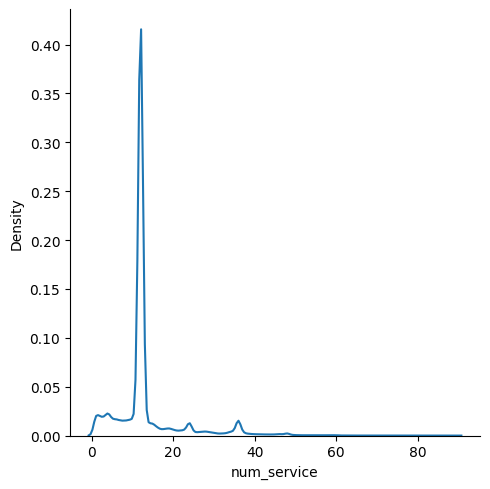

In [18]:
sns.displot(recipient, x="num_service", kind="kde")


In [114]:
df[df.id == 1626]

,id,date,service,age,gender,race,ethnicity,marital,education,month,serv,age_bin
0,1626,2021-01-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),January,S01,0-9
1,1626,2021-02-28,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),February,S01,0-9
2,1626,2021-03-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),March,S01,0-9
3,1626,2021-04-30,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),April,S01,0-9
4,1626,2021-05-31,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),May,S01,0-9
5,1626,2021-06-30,Children_Attending_Early_Childhood_Programs_Ma...,5,1~Male,1~White,99~Unknown,99~Unknown,9-12~High School (grade 9-12),June,S01,0-9


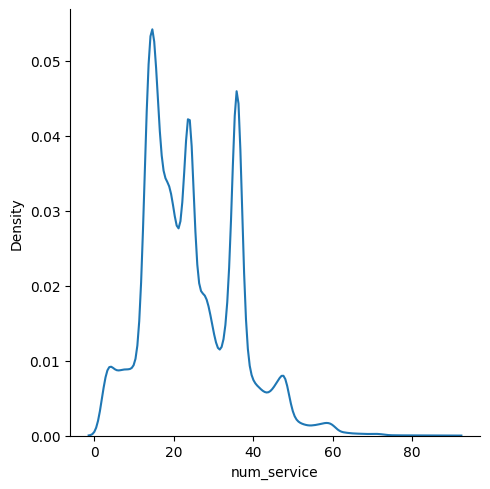

In [19]:
sns.displot(recipient[recipient.distinct_service > 1], x="num_service",kind='kde')


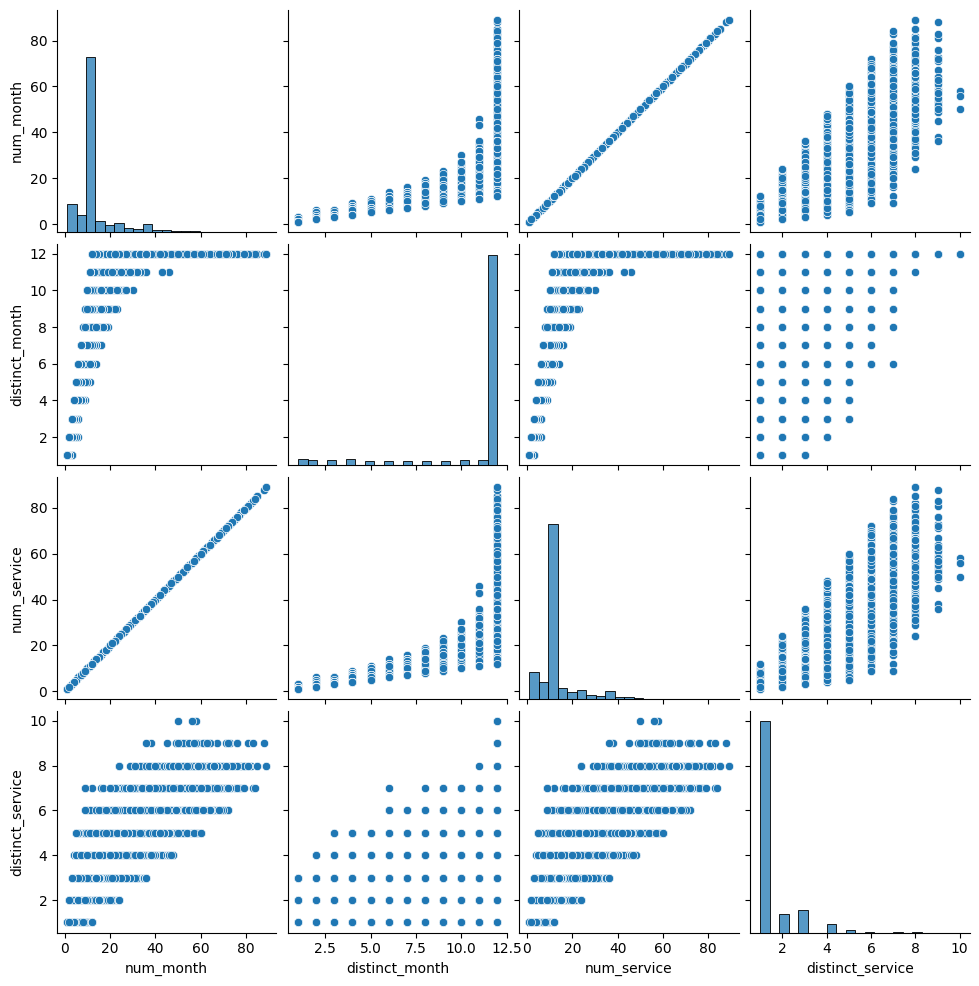

In [20]:
#make a scatterplot between age and number of services in the client_attributes dataset
sns.pairplot(data = recipient[["num_month", "distinct_month", "num_service","distinct_service","gender","race",'age_bin']])


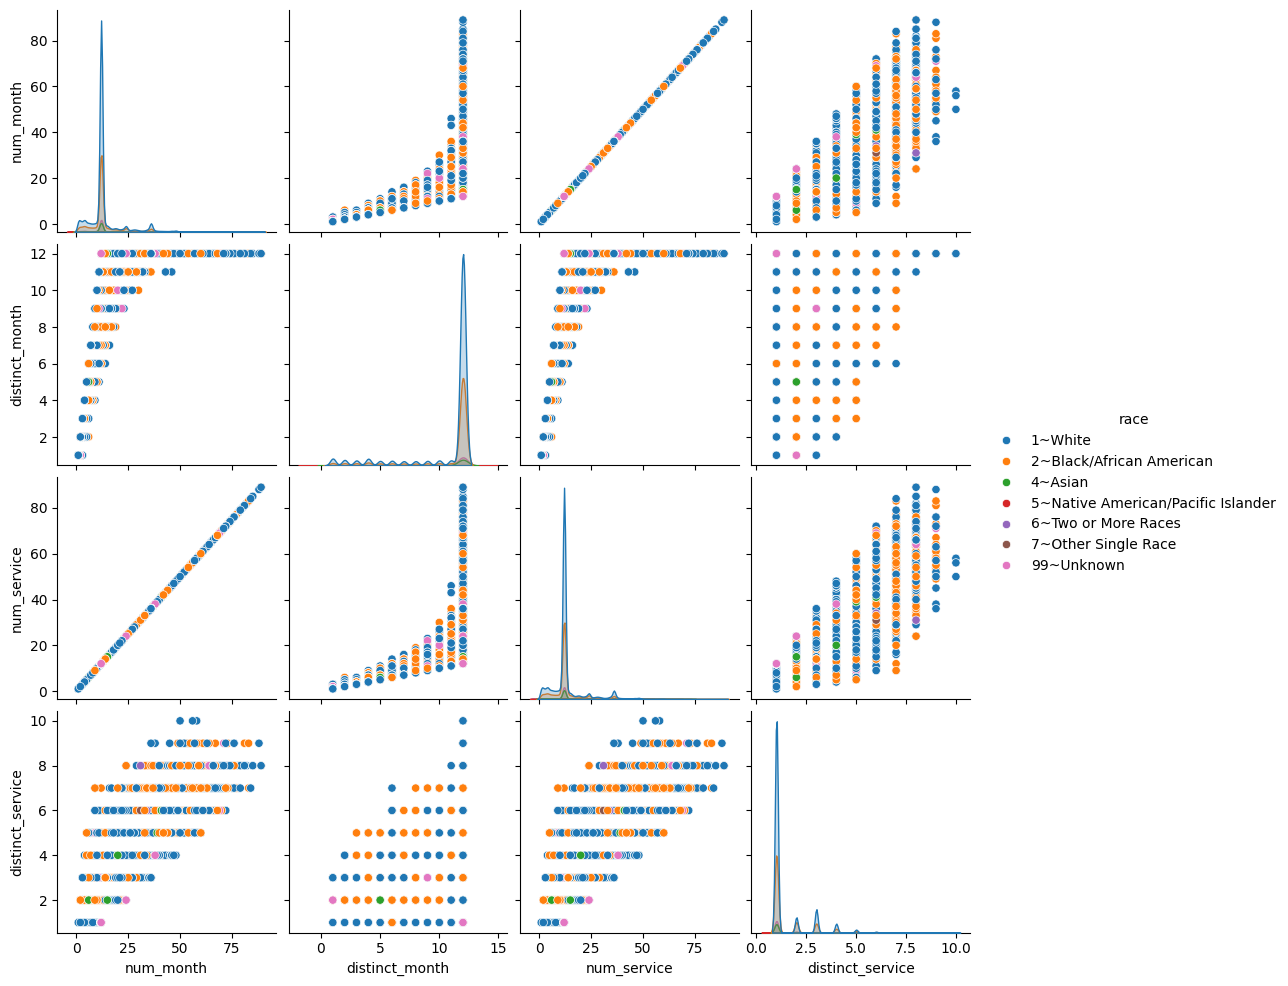

In [21]:
sns.pairplot(data = recipient[["num_month", "distinct_month", "num_service","distinct_service","gender","race",'age_bin']],hue='race')

Hmmm... not sure what to make out of this, but we can see something in the single variable distributions, so let's plot that

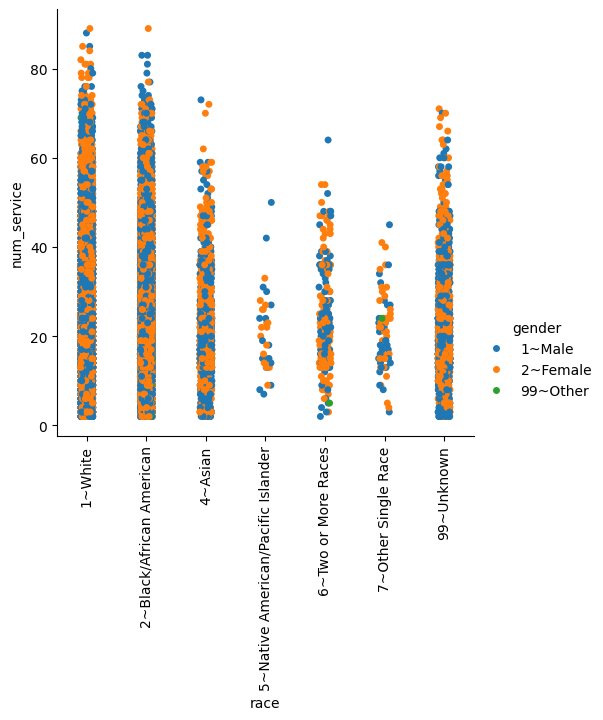

In [22]:

sns.catplot(data = recipient.query("distinct_service > 1"), x="race", y="num_service", hue="gender")
plt.xticks(rotation=90)
plt.show()

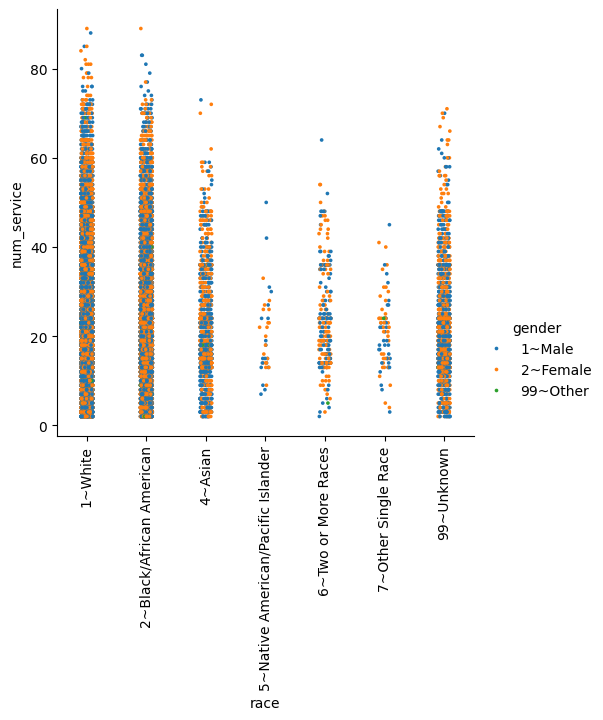

In [23]:
sns.catplot(data = recipient.query("distinct_service > 1"), x="race", y="num_service", hue="gender",s=7)
plt.xticks(rotation=90)
plt.show()


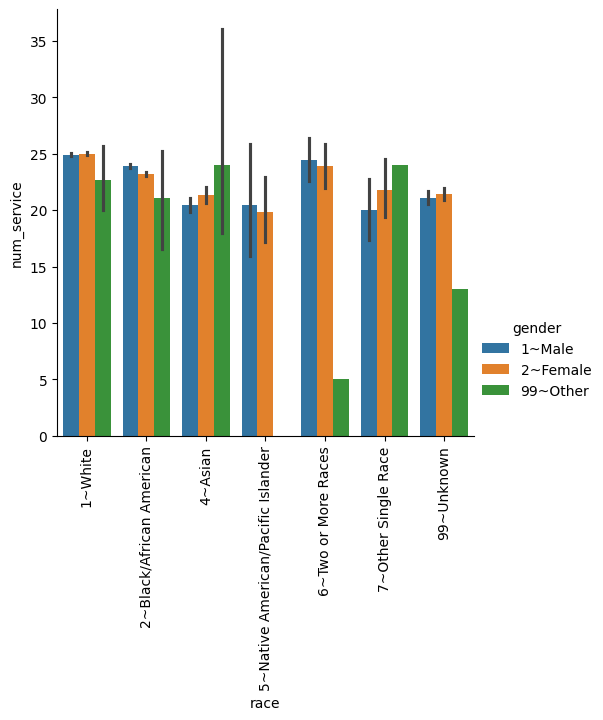

In [24]:
import matplotlib.pyplot as plt
sns.catplot(data = recipient.query("distinct_service > 1"), 
            x="race", y="num_service", hue="gender",kind="bar")
plt.xticks(rotation=90)
plt.show()

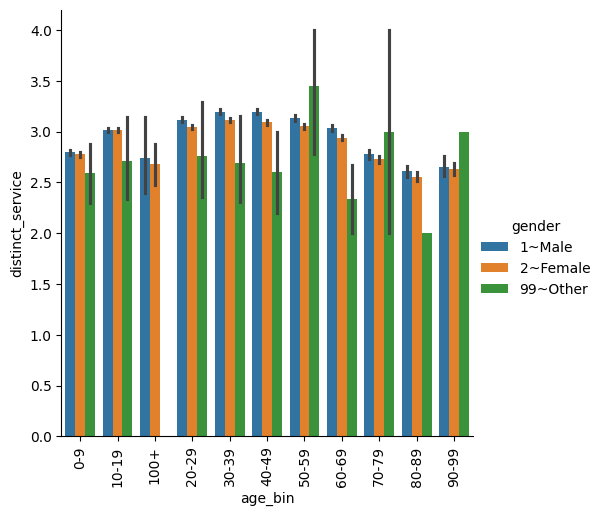

In [25]:
import matplotlib.pyplot as plt
sns.catplot(data = recipient.query("distinct_service > 1"), 
            x="age_bin", y="distinct_service", hue="gender",kind="bar")
plt.xticks(rotation=90)
plt.show()

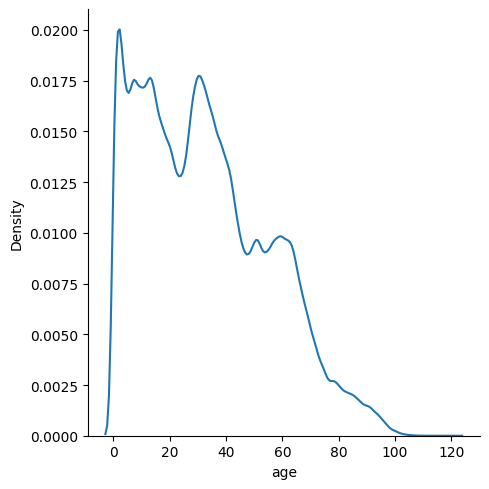

In [26]:
sns.displot(df,x='age',kind='kde')

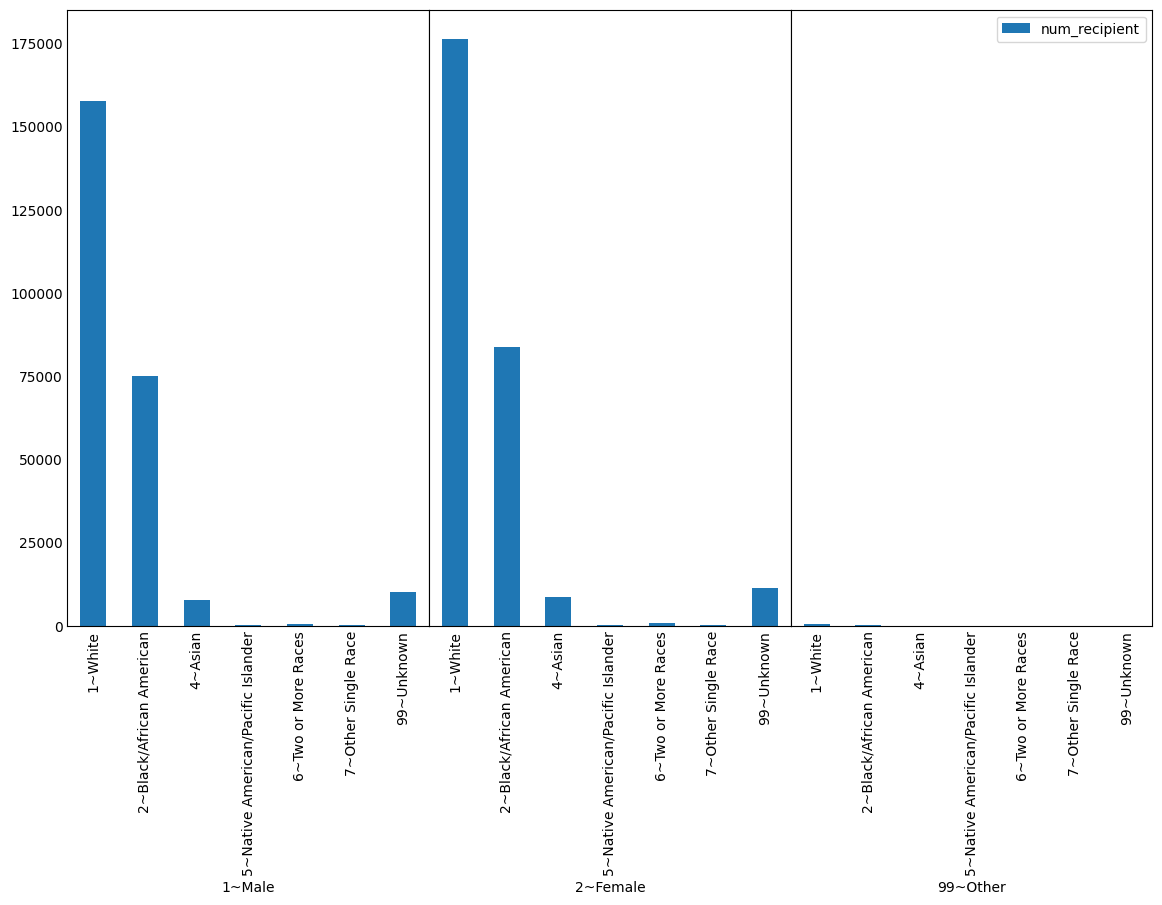

In [27]:
df1 = df.groupby(['race','gender']).agg(
    num_recipient= ('id', 'nunique')
).reset_index()

groups = df1.groupby("gender")
fig, axes = plt.subplots(1, len(groups), sharey=True, figsize=(14,8))

for ax, (gender, group) in zip(axes, groups):
    # The rename_axis function makes the difference
    group.set_index("race").rename_axis(gender)["num_recipient"].plot(kind="bar", ax=ax)
    ax.tick_params(axis='both', which='both', length=0)

ax.legend()
fig.subplots_adjust(wspace=0)

# copied from https://stackoverflow.com/questions/74062380/plot-both-multi-index-labels-on-x-axis-in-pandas-plot


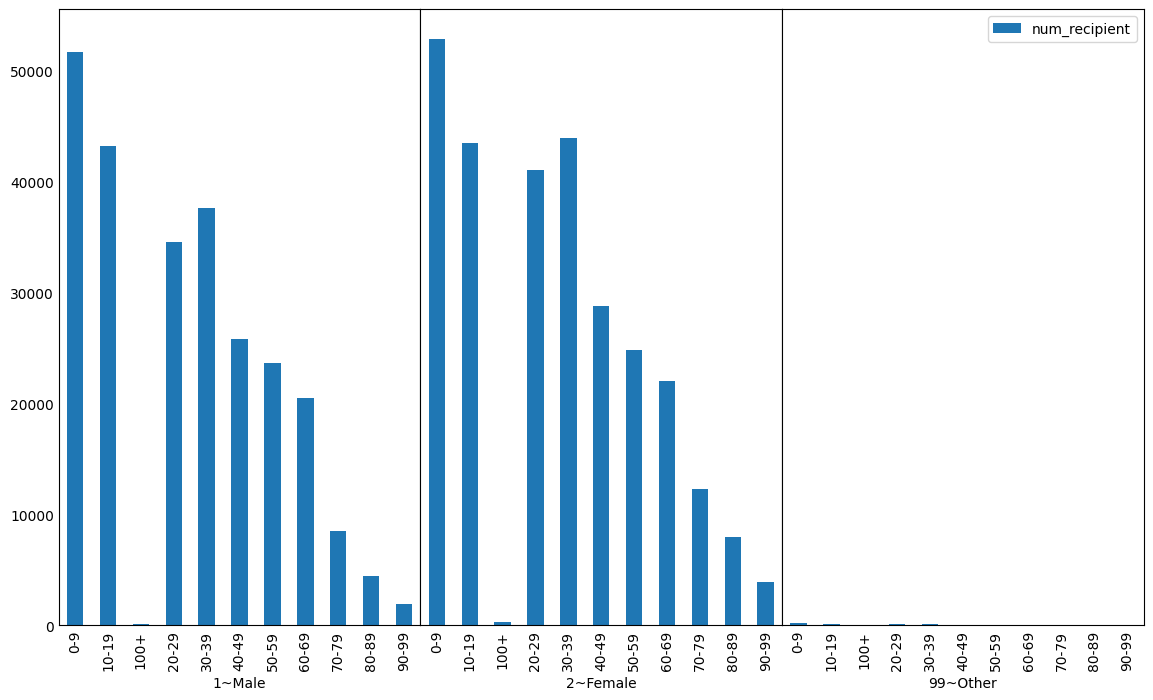

In [28]:
df1 = df.groupby(['age_bin','gender']).agg(
    num_recipient= ('id', 'nunique')
).reset_index()

groups = df1.groupby("gender")
fig, axes = plt.subplots(1, len(groups), sharey=True, figsize=(14,8))

for ax, (gender, group) in zip(axes, groups):
    # The rename_axis function makes the difference
    group.set_index("age_bin").rename_axis(gender)["num_recipient"].plot(kind="bar", ax=ax)
    ax.tick_params(axis='both', which='both', length=0)

ax.legend()
fig.subplots_adjust(wspace=0)

# copied from https://stackoverflow.com/questions/74062380/plot-both-multi-index-labels-on-x-axis-in-pandas-plot


* these are actual values, not statistical estimates as plot in catplot when feeding with dataframes
* this says more than 50k male children younger than 10 receiving some services 
* we can verify with a simple query

In [29]:
df.query("age < 10 and gender == '1~Male'").id.nunique()

51649

In [30]:
df.sort_values(["id","date"]).head(30)


,id,date,service,age,gender,race,ethnicity,marital,education,month,serv,age_bin
963041,1,2021-01-31,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,January,S12,10-19
963042,1,2021-02-28,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,February,S12,10-19
963043,1,2021-03-31,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,March,S12,10-19
963044,1,2021-04-30,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,April,S12,10-19
963045,1,2021-05-31,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,May,S12,10-19
963046,1,2021-06-30,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,June,S12,10-19
963047,1,2021-07-31,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,July,S12,10-19
963048,1,2021-08-31,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,August,S12,10-19
963049,1,2021-09-30,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,September,S12,10-19
963050,1,2021-10-31,Individuals_Receiving_Income_Supports,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,October,S12,10-19


### clean up
* put all functions into a python code file dhs_util.py, perhaps save in the same directory (folder) as you hold your notebooks
* future use can just call "import dhs_util" or "from dhs_util import *" at the beginning of the notebook

### pivot tables

In [84]:
df1 = pd.pivot_table(df, values='id', index=['service'], columns=['date'], aggfunc="nunique")
df1

date,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31
service,,,,,,,,,,,,
Children_Attending_Early_Childhood_Programs_Managed_by_DHS,209,215,212,216,216,217,79,179,187,190,192,190
Children_Receiving_Child_Welfare_Services,4391,4493,4567,4611,4449,4411,4370,4266,4174,3788,3623,3230
Children_Receiving_DHS_Funded_Out_of_School_Programs,298,315,392,383,344,369,440,379,390,512,411,373
Children_Receiving_Early_Intervention_Services,3050,3313,3520,3685,3821,3977,4137,4348,4432,4217,3980,3443
Children_in_Care,1508,1559,1584,1589,1567,1594,1575,1638,1593,1573,1442,1220
Families_Receiving_Child_Welfare_Services,2065,2013,2053,2001,2069,2012,2070,2104,1999,1875,1684,1528
Homeless_Population,1105,1145,1163,1246,1241,1179,1158,1185,1119,996,1092,1321
Homicides,18,6,9,20,15,14,14,29,9,10,18,10
Individuals_Receiving_DHS_Services,53064,53307,54538,54405,53633,53416,52656,52514,52549,49676,49049,47915


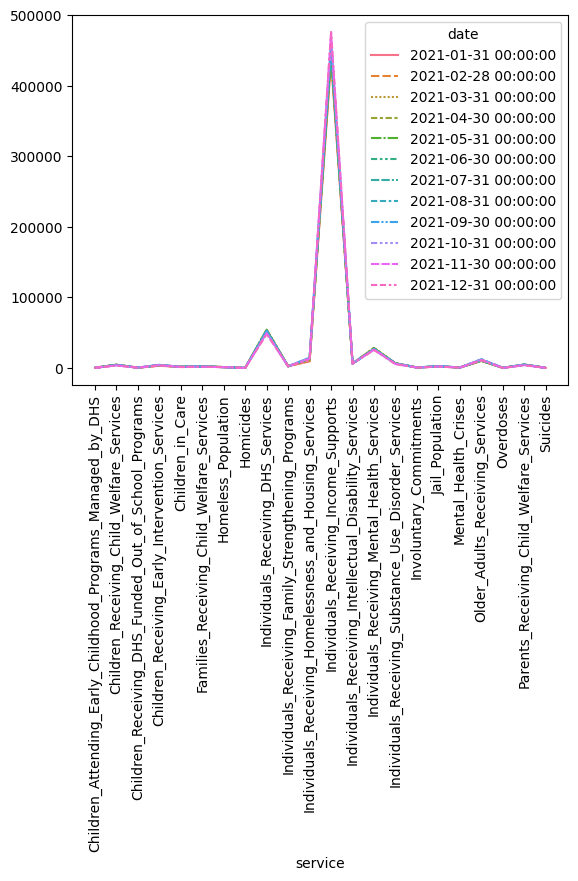

In [91]:
sns.lineplot(df1)
plt.xticks(rotation = 90)
plt.show()

* the above says similar volumes across different services for each month
* what about for each service the changes over months?
* we can pivot the ways that transpose the above

In [44]:
df2 = pd.pivot_table(df, values='id', columns=['serv'], index=['date'], aggfunc="nunique")
df2.head()

serv,S01,S03,S04,S05,S02,S06,S07,S08,S09,S10,...,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22
date,,,,,,,,,,,,,,,,,,,,,
2021-01-31,209,4391,298,3050,1508,2065,1105,18,53064,2420,...,6140,27320,6477,558,2018,675,10091,118,4501,81
2021-02-28,215,4493,315,3313,1559,2013,1145,6,53307,2393,...,6133,27612,6522,522,2020,604,10096,84,4617,99
2021-03-31,212,4567,392,3520,1584,2053,1163,9,54538,2396,...,6154,28761,6686,691,2180,690,10263,113,4683,108
2021-04-30,216,4611,383,3685,1589,2001,1246,20,54405,2375,...,6175,28355,6548,646,2236,628,10037,111,4771,86
2021-05-31,216,4449,344,3821,1567,2069,1241,15,53633,2369,...,6174,27448,6394,633,2353,639,10109,122,4718,81


<Axes: xlabel='date'>

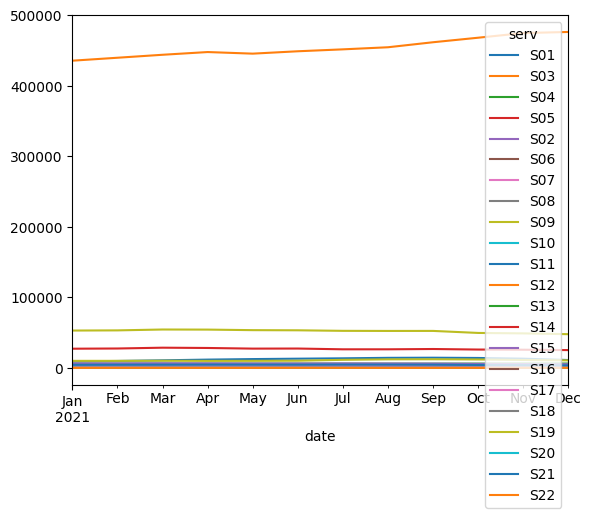

In [93]:
df2.plot()

* looked stable over months, but hard to tell, the scale of changes is overwhelmed by the scale of absolute values
* when this happens, consider "normalization", rather, to scale the data

* use mean normalization

<Axes: xlabel='date'>

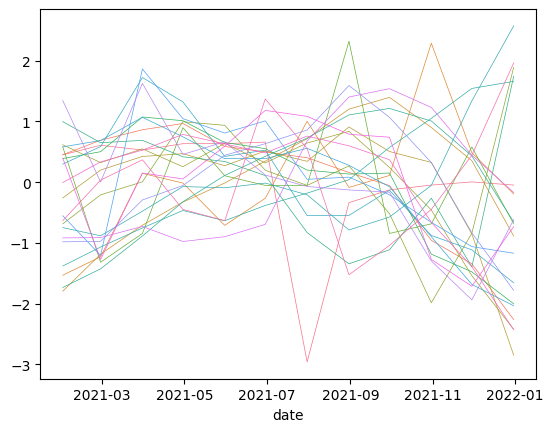

In [81]:
sns.lineplot((df2 - df2.mean())/(df2.std()),lw=0.5,dashes=False,legend=None)

* using min-max scaler

<Axes: xlabel='date'>

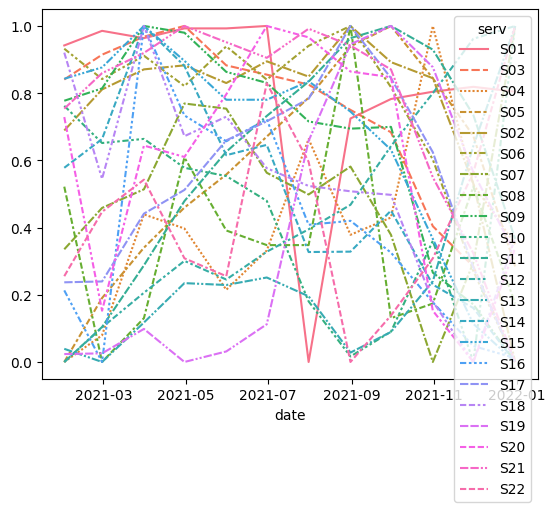

In [80]:
sns.lineplot((df2 - df2.min())/(df2.max()-df2.min()))

In [32]:
df1 = get_recipient_month_attribute(df)
df1.head()

,id,date,num_service,age,gender,race,ethnicity,marital,education,serv,age_bin
0,1,2021-01-31,1,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,S12,10-19
12,1,2021-02-28,1,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,S12,10-19
24,1,2021-03-31,1,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,S12,10-19
36,1,2021-04-30,1,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,S12,10-19
48,1,2021-05-31,1,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,S12,10-19


In [33]:
df2 = pd.pivot(df1, values='num_service', index=['id'], columns=['date'])
df2

date,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31
id,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,0,0,0,0,0,1,1,0,1
5,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
535604,2,3,2,2,2,1,1,2,3,1,2,1
535605,1,1,1,2,1,1,1,2,1,1,1,1
535606,2,3,1,1,3,2,0,2,1,2,2,2


In [102]:
df_temp = df[["id", "serv"]].drop_duplicates()
df_temp["val"]= 1
df_temp.head()

,id,serv,val
0,1626,S01,1
6,3775,S01,1
18,5570,S01,1
24,6022,S01,1
28,7912,S01,1


In [103]:
df3 = df_temp.pivot(index=['id'], columns=['serv'],values="val")
df3.head()

serv,S01,S03,S04,S05,S02,S06,S07,S08,S09,S10,...,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22
id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
df3.count(axis="columns")

id
1         1
2         1
3         1
4         1
5         1
         ..
535604    3
535605    3
535606    3
535607    5
535608    1
Length: 533799, dtype: int64

In [100]:
df_temp = df[["id", "serv"]].drop_duplicates()
df4 = df_temp.unstack(fill_value=0)
df4.head(30)


id  0       1626
    6       3775
    18      5570
    24      6022
    28      7912
    34      9265
    40     11411
    46     13104
    58     14728
    64     16102
    70     16240
    75     17592
    79     19600
    85     19695
    86     20431
    92     21930
    97     24929
    102    25485
    108    26247
    110    26780
    115    29676
    120    30890
    123    32046
    129    32874
    135    33528
    140    34376
    146    35247
    152    35540
    158    35885
    170    36634
dtype: object

In [37]:
df4

id    0          1626
      6          3775
      18         5570
      24         6022
      28         7912
                 ... 
serv  7116129     S22
      7116130     S22
      7116131     S22
      7116132     S22
      7116133     S22
Length: 1507906, dtype: object

### joins 

* to answer the question of "how many people used service x and service y


In [38]:
df1 =df[["id","serv"]].merge(df[["id","serv"]], on="id",how="inner")


In [39]:
df1.query("serv_x != serv_y").groupby(["serv_x","serv_y"]).nunique().sort_values("id", ascending = False)

/var/folders/j8/w88cxj05115byx3n9mnk572w0000gn/T/ipykernel_2468/2190627728.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df1.query("serv_x != serv_y").groupby(["serv_x","serv_y"]).nunique().sort_values("id", ascending = False)


id
serv_x serv_y       
S09    S12     74268
S12    S09     74268
S14    S09     55263
S09    S14     55263
S14    S12     50410
...              ...
S09    S09         0
S08    S22         0
       S13         0
       S08         0
S22    S22         0

[484 rows x 1 columns]

### working with time

* how do the recipients use the services in a sequential manner? 

In [40]:
serv_data = []
for groups in df.groupby(['id', 'date']).groups.values():
    serv_data.append(df.loc[groups]['serv'].tolist())


## In class exercises
Answer the following questions:
 - how many recipients receive services every month in the year? 
 - what is the average number of services a recipient use? 
 - if we remove the recipients who uses only one service in the year, what are the answers to the above questions?
 - from all the plots, can we conclude that there is little difference in the number of services used between different age/gender/race groups?